In [1]:
from fastai.vision.all import *
from PIL import ImageOps

In [2]:
path = Path()/'datasets/bears/teddys'
teddys = (path).ls().sorted()

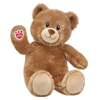

In [3]:
img = Image.open(teddys[1]).resize((100, 100))
img

In [4]:
array(img)[200:202, 200: 202]

array([], shape=(0, 0, 3), dtype=uint8)

In [5]:
tensor(img)[200:202, 200:202]

tensor([], size=(0, 0, 3), dtype=torch.uint8)

In [6]:
img_o = Image.open(teddys[1])
img = ImageOps.grayscale(img_o)
img_t = tensor(img)
img_t.shape

torch.Size([500, 500])

In [7]:
df = pd.DataFrame(img_t[200:210, 200: 210])
df.style.set_properties().background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9
0,172,161,155,150,135,117,115,126,153,137
1,138,145,145,132,116,114,128,142,142,133
2,113,129,134,122,118,131,145,148,121,114
3,110,118,124,129,142,154,150,136,122,110
4,114,114,121,138,153,156,146,137,138,125
5,120,123,132,142,146,145,148,155,130,125
6,125,134,138,134,134,143,150,151,120,122
7,125,134,130,118,126,146,143,124,133,135
8,135,115,102,104,110,114,127,143,137,136
9,103,92,93,108,113,108,114,128,139,149


In [8]:
full_teddys = [tensor(ImageOps.grayscale(Image.open(i).resize((50, 50)))) for i in (path).ls()]
full_tomato = [tensor(ImageOps.grayscale(Image.open(i).resize((50, 50)))) for i in (Path.cwd()/'datasets/Tomato_leaf/Healthy').ls()]

In [9]:
print(full_teddys[1].shape, type(full_teddys))
print(full_tomato[1].shape)

torch.Size([50, 50]) <class 'list'>
torch.Size([50, 50])


In [10]:
stacked_teddys = torch.stack(full_teddys).float()/255
stacked_tomato = torch.stack(full_tomato).float()/255

In [11]:
stacked_teddys.shape, stacked_tomato.shape

(torch.Size([172, 50, 50]), torch.Size([1591, 50, 50]))

In [12]:
len(stacked_teddys.shape), len(stacked_tomato.shape)

(3, 3)

In [13]:
stacked_teddys.dim(), stacked_tomato.dim()

(3, 3)

In [14]:
stacked_teddys.mean(), stacked_tomato.mean()

(tensor(0.7202), tensor(0.4557))

<AxesSubplot:>

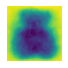

In [16]:
mean_teddy = stacked_teddys.mean(0)
show_image(mean_teddy)

<AxesSubplot:>

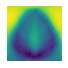

In [17]:
mean_tomato = stacked_tomato.mean(0)
show_image(mean_tomato)

In [18]:
import matplotlib.pyplot as plt

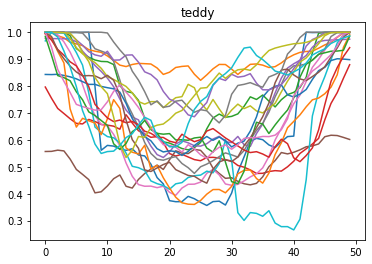

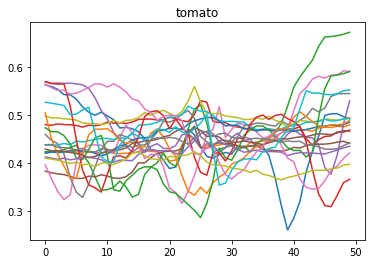

In [19]:
for i in range(0, 20):
    plt.plot(stacked_teddys[i].mean(0))
plt.title('teddy')
plt.show()

for i in range(0, 20):
    plt.plot(stacked_tomato[i].mean(0))
plt.title('tomato')
plt.show()

In [20]:
def bear_distance(x, mean): return (x-mean).abs().mean((-1, -2))

In [21]:
bear_distance(stacked_teddys[1], mean_teddy)

tensor(0.1890)

In [22]:
def is_bear(x): return bear_distance(x, mean_teddy) < bear_distance(x, mean_tomato)

In [23]:
is_bear(stacked_teddys[1]), is_bear(stacked_teddys[1]).float()

(tensor(True), tensor(1.))

In [24]:
accuracy_teddy = is_bear(stacked_teddys[1]).float().mean()
accuracy_tomato = 1 - is_bear(stacked_tomato[1]).float().mean()

accuracy_teddy, accuracy_tomato

(tensor(1.), tensor(1.))

# Buliding Model

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# Splitting data
tomato = Path.cwd()/'datasets/Tomato_leaf/Healthy'
bear = Path()/'datasets/bears/teddys'

full_teddys = [tensor(ImageOps.grayscale(Image.open(i).resize((50, 50)))) for i in (bear).ls()]
full_tomato = [tensor(ImageOps.grayscale(Image.open(i).resize((50, 50)))) for i in (tomato).ls()]

In [27]:
train_teddy, valid_teddy = train_test_split(full_teddys)
train_tomato, valid_tomato = train_test_split(full_tomato)

In [28]:
stacked_train_teddy = torch.stack(train_teddy).float()/255
stacked_valid_teddy = torch.stack(valid_teddy).float()/255
stacked_train_tomato = torch.stack(train_tomato).float()/255
stacked_valid_tomato = torch.stack(valid_tomato).float()/255

In [29]:
train_x = torch.cat([stacked_train_teddy, stacked_train_tomato]).view(-1, 50*50)
train_y = torch.cat([tensor([0]*len(train_teddy)), tensor([1]*len(train_tomato))]).view(-1, 1)
valid_x = torch.cat([stacked_valid_teddy, stacked_valid_tomato]).view(-1, 50*50)
valid_y = torch.cat([tensor([0]*len(valid_teddy)), tensor([1]*len(valid_tomato))]).view(-1, 1)

In [30]:
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

(torch.Size([1322, 2500]),
 torch.Size([1322, 1]),
 torch.Size([441, 2500]),
 torch.Size([441, 1]))

In [31]:
dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))
x, y = dset[0]
x.shape, y

(torch.Size([2500]), tensor([0]))

In [32]:
xy, yy = valid_dset[0]
xy.shape, yy

(torch.Size([2500]), tensor([0]))

In [33]:
from matplotlib.pyplot import imshow

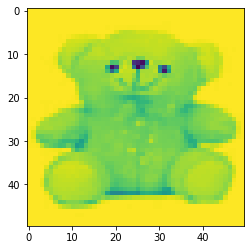

In [34]:
imshow(array(xy.view(50, 50)))

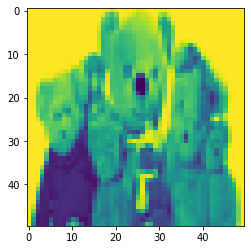

In [35]:
imshow(array(x.view(50, 50)))

In [36]:
data = tensor([1., 2., 4.])
data_y = tensor([1., 0., 1.])

In [47]:
# step 1 initializing parameters
def init_params(size, std=0.01):
    return (torch.randn(size)*std).requires_grad_()

# step 2 forward propagate

def linear1(data, params):
    return data@params[0] + params[1]
    
 # step 3 computing cost
def sigmoid_activation(x):
    return 1/1+torch.exp(-x)

def loss_or_cost(predicted, actual):
    predicted = sigmoid_activation(predicted)
    return torch.where(actual==1, 1 - predicted, predicted).float().mean()
    
#step 4 backward propogate
  
def cal_grad(data, actual, model, params):
    preds = model(data, params)
    loss = loss_or_cost(preds, actual)
    loss.backward()

In [48]:
# step 5 update parameters

class BasicOptim:
    def __init__(self, params, lr): 
        self.params = params
        self.lr = lr
        
    def step(self):
        for p in self.params: 
            p.data -= p.grad.data * self.lr
    
    def zero_grad(self):
        for p in self.params:
            p.grad = None

In [49]:
def batch_accuracy(x, y):
    preds = x.sigmoid()
    correct = (preds > .5) == y
    return correct.float().mean()

def validate_epoch(model, params):
    acc = [batch_accuracy(model(x, params), y) for x, y in valid_dset]
    return round(torch.stack(acc).mean().item(), 4)
# training 

def train_epoch(model, opt, params):
    for x, y in dset:
        cal_grad(x, y, linear1, params)
        opt.step()
        opt.zero_grad()

In [50]:
def train_model(model, epochs):
    params = params = init_params(50*50, 1), init_params(1,1)
    opt = BasicOptim(params, .001)
    
    for i in range(epochs):
        train_epoch(model, opt, params)
        print(validate_epoch(model, params), end=' ')

In [51]:
train_model(linear1, 20)

0.9048 0.9048 0.9048 0.9048 0.9048 0.9093 0.9116 0.9048 0.9048 0.9048 0.9048 0.9048 0.9048 0.9048 0.9093 0.0975 0.0975 0.0975 0.0975 0.0975 

### Putting all with inbuilt

In [59]:
dl = DataLoader(dset, batch_size=len(dset)//10, shuffle=True)
x, y = first(dl)
x.shape, y.shape

(torch.Size([132, 2500]), torch.Size([132, 1]))

In [60]:
valid_dl = DataLoader(valid_dset, batch_size=len(valid_dset)//10)

In [61]:
batch = train_x[:4]
batch.shape

torch.Size([4, 2500])

In [64]:
preds = linear1(batch, [init_params(50*50, 1), init_params(1, 1)])
preds

tensor([ 2.0046, 14.4218, 19.4997, 21.7516], grad_fn=<AddBackward0>)

In [66]:
loss = loss_or_cost(preds, train_y[:4])
loss

tensor(1.0337, grad_fn=<MeanBackward0>)

In [99]:
def loss_or_cost(predicted, actual):
    predicted = sigmoid_activation(predicted)
    return torch.where(actual==1, 1 - predicted, predicted).float().mean()

def calc_grad(x, y, model):
    preds = model(x)
    loss = loss_or_cost(preds, y)
    loss.backward()

In [73]:
def batch_accuracy(x, y):
    preds = x.sigmoid()
    correct = (preds>.5) == y
    return correct.float().mean()

In [78]:
def validate_epoch(model):
    accs = [batch_accuracy(model(x), y) for x, y in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [80]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [89]:
def train_epoch(model):
    for x, y in dl:
        calc_grad(x, y, model)
        opt.step()
        opt.zero_grad()
        
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end = ' ')

In [93]:
linear_model = nn.Linear(50*50, 1)
opt = SGD(linear_model.parameters(), 0.001)
train_model(linear_model, 20)

0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 0.9112 

In [96]:
dls = DataLoaders(dl, valid_dl)

In [101]:
learn = Learner(dls, nn.Linear(50*50, 1), opt_func=SGD,
               loss_func = loss_or_cost, metrics=batch_accuracy)

In [105]:
learn.fit(10, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.087567,0.097506,0.902494,00:00
1,0.115311,0.097506,0.902494,00:00
2,0.103993,0.097506,0.902494,00:00
3,0.098558,0.097506,0.902494,00:00
4,0.095509,0.097506,0.902494,00:00
5,0.093370,0.097506,0.902494,00:00
6,0.092025,0.097506,0.902494,00:00
7,0.102803,0.097506,0.902494,00:00
8,0.099419,0.097506,0.902494,00:00
9,0.096952,0.097506,0.902494,00:00
